Load posteriors $p(\chi|F_i)$. The mesh size is 40x40 for $[-1\cdots+1]^2$.

In [2]:
OneH = np.loadtxt(open("IhST2.twhist", "r"))
OneC = np.loadtxt(open("IcST2.twhist", "r"))
LDL  = np.loadtxt(open("LDLST2.twhist", "r"))
HDL  = np.loadtxt(open("HDLST2.twhist", "r"))

X = np.vstack([LDL.reshape([1600,]),
               HDL.reshape([1600,]),
               OneH.reshape([1600,]),
               OneC.reshape([1600,]),]).T

pxF = {"HDL": HDL, "LDL": LDL, "1c": OneC, "1h": OneH}

Load $\chi$ distribution of the target, $p(\chi)$.

In [3]:
pX = np.loadtxt(open("target.twhist", "r"))

Estimate the components $p(F_i)$ in the target by linear regression.

In [4]:
from sklearn import linear_model

Y = pX.reshape([1600,])
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X,Y)

pF = {"LDL": reg.coef_[0],
      "HDL": reg.coef_[1],
      "1h":  reg.coef_[2],
      "1c":  reg.coef_[3],}
pF

{'LDL': 0.3498589246439634,
 'HDL': 0.6114011567677509,
 '1h': 0.025863750944862263,
 '1c': 0.04936821774023342}

Calculate the likelihoods $p(F_i|\chi)$ for each mesh points $\chi$ on the complex plane by Bayes' theorem.

In [ ]:
pFx = dict()
for phase in ("HDL", "LDL", "1h", "1c"):
    pFx[phase] = pxF[phase]*pF[phase] / pX
    pFx[phase][pX==0] = 0
    
pFx["ice"] = pFx["1h"] + pFx["1c"]

### L coloring scheme
L coloring scheme is a mixed coloring by the likelihoods.

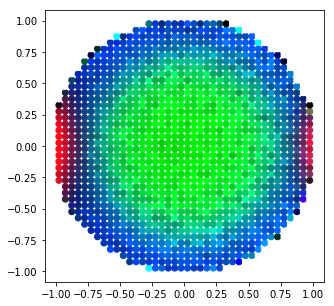

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

r = np.clip(pFx["ice"],0,1)
g = np.clip(pFx["HDL"],0,1)
b = np.clip(pFx["LDL"],0,1)
r[pX==0] = 1.0
g[pX==0] = 1.0
b[pX==0] = 1.0

r = (r*255).astype(int)
g = (g*255).astype(int)
b = (b*255).astype(int)

colors = np.array(["#{0:02x}{1:02x}{2:02x}".format(r[x,y], g[x,y], b[x,y]) for y in range(40) for x in range(40)])

plt.rcParams['figure.figsize'] = [5, 5]
row, col = np.meshgrid(np.arange(-1+0.025,1.,0.05), np.arange(-1+0.025,1.,0.05))

plt.scatter(row,col, c=colors)
# plt.savefig("Lcoloring.svg")
# plt.savefig("Lcoloring.png")
plt.show()

### DB coloring scheme
In DB coloring scheme, the map is colored based on the phase of the highest likelihood.

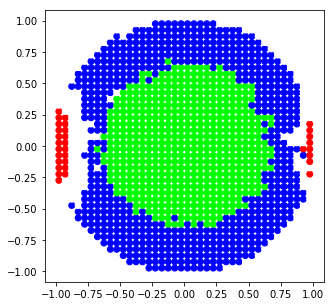

In [9]:
from matplotlib import pyplot as plt

r = np.ones_like(pFx["ice"])
g = np.ones_like(pFx["ice"])
b = np.ones_like(pFx["ice"])

r[pFx["ice"] > 0.5]=1.0
g[pFx["ice"] > 0.5]=0.0
b[pFx["ice"] > 0.5]=0.0

r[pFx["HDL"] > 0.5]=0.0
g[pFx["HDL"] > 0.5]=1.0
b[pFx["HDL"] > 0.5]=0.0

r[pFx["LDL"] > 0.5]=0.0
g[pFx["LDL"] > 0.5]=0.0
b[pFx["LDL"] > 0.5]=1.0

r = (r*255).astype(int)
g = (g*255).astype(int)
b = (b*255).astype(int)

colors = np.array(["#{0:02x}{1:02x}{2:02x}".format(r[x,y], g[x,y], b[x,y]) for y in range(40) for x in range(40)])

plt.rcParams['figure.figsize'] = [5, 5]
row, col = np.meshgrid(np.arange(-1+0.025,1.,0.05), np.arange(-1+0.025,1.,0.05))

plt.scatter(row,col, c=colors)
# plt.savefig("DBcoloring.svg")
# plt.savefig("DBcoloring.png")
plt.show()

### FB coloring scheme
In FB coloring scheme, colors are fixed regardless of real $\chi$ distribution.

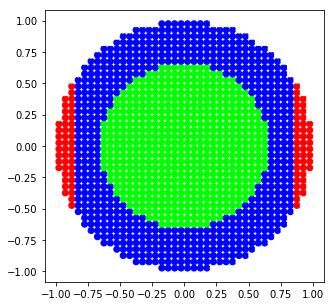

In [10]:
row, col = np.meshgrid(np.arange(-1+0.025,1.,0.05), np.arange(-1+0.025,1.,0.05))

RR = (row**2 + col**2)**0.5

r = np.ones_like(pFx["ice"])
g = np.ones_like(pFx["ice"])
b = np.ones_like(pFx["ice"])

r[RR<0.65] = 0.0
g[RR<0.65] = 1.0
b[RR<0.65] = 0.0

r[RR>=0.65] = 0.0
g[RR>=0.65] = 0.0
b[RR>=0.65] = 1.0

r[col>=0.85] = 1.0
g[col>=0.85] = 0.0
b[col>=0.85] = 0.0

r[col<-0.85] = 1.0
g[col<-0.85] = 0.0
b[col<-0.85] = 0.0

r[RR>1.0] = 1.0
g[RR>1.0] = 1.0
b[RR>1.0] = 1.0

r = (r*255).astype(int)
g = (g*255).astype(int)
b = (b*255).astype(int)

colors = np.array(["#{0:02x}{1:02x}{2:02x}".format(r[x,y], g[x,y], b[x,y]) for y in range(40) for x in range(40)])

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(row, col, c=colors)
# plt.savefig("FBcoloring.svg")
# plt.savefig("FBcoloring.png")
plt.show()

----

**The following codes are for preparing figures in the paper. They are useless without the original data.**

## Preparation of the histograms
Prepare posterior distributions $p(\chi|F_i)$. It requires the original data.

In [1]:
import numpy as np

def valueloader(file):
    """
    Read twists in @BTWC format analysed with analice command.
    """
    vals = []
    for line in file.readlines():
        if line[0] == "#":
            continue
        cols = line.split()
        if len(cols) == 7 and cols[0][0] != '-' and -1 == line.find("@") and cols[6] != "0.0000":
            vals.append([float(x) for x in cols[2:7]])
            #seven columns of @BTWC are:
            # 1,2 : water labels
            # 3,4,5: x,y,z; center of the bond
            # 6,7: real, ideal twist
    return np.array(vals)

In [ ]:
The following codes are for preparing figures in the paper. They are useless without the original data.

import os
import numpy as np

files = [["LDL", "cat /Volumes/workarea/work/LL-yaga/ST2-for-tknbn/240K-0.88/000[5-9]?.btwc", "LDLST2"],
         ["HDL", "cat /Volumes/workarea/work/LL-yaga/ST2-for-tknbn/240K-1.04/001[0-4]?.btwc", "HDLST2"],
         ["Ih", "cat /Volumes/workarea/work/NPT-ST2/Ih/P-1_T-235/1h.btwc", "IhST2"],
         ["Ic", "cat /Volumes/workarea/work/NPT-ST2/Ic/P-1_T-235/Ic.btwc", "IcST2"],
         ["LL", "cat /Volumes/workarea/work/LL-yaga/ST2-for-tknbn/235K-0.98/007[567][0-9].btwc", "target"],
        ]

for title, infilename, ty in files:
    vals = valueloader(os.popen(infilename))

    zs    = vals[:,2]
    chirs = vals[:,3]
    chiis = vals[:,4]
    hist  = np.histogram2d(chirs, chiis, bins=(40,40), range=[[-1.,1.],[-1.,1.]], normed=True)
    np.savetxt(ty+".twhist", hist[0])
    print(title, np.sum(hist[0]))

## Time evolution of the composition

In [ ]:
OneH = np.loadtxt(open("IhST2.twhist", "r"))
OneC = np.loadtxt(open("IcST2.twhist", "r"))
LDL  = np.loadtxt(open("LDLST2.twhist", "r"))
HDL  = np.loadtxt(open("HDLST2.twhist", "r"))

In [ ]:
The following codes are for preparing figures in the paper. They are useless without the original data.

import os
from sklearn import linear_model

X = np.vstack([LDL.reshape([1600,]),
               HDL.reshape([1600,]),
               OneH.reshape([1600,]),
               OneC.reshape([1600,]),]).T

LEN=88
fits = np.zeros([LEN,4])
for fn in range(LEN):
    vals = valueloader(os.popen("cat /Volumes/workarea/work/LL-yaga/ST2-for-tknbn/235K-0.98/00{0:02d}[0-9].btwc".format(fn)))
    chirs = vals[:,3]
    chiis = vals[:,4]

    Htarget = np.histogram2d(chirs, chiis, bins=(40,40), range=[[-1.,1.],[-1.,1.]], normed=True)
    Y = Htarget[0].reshape([1600,])
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(X,Y)
    # print(fn, reg.coef_) # , reg.intercept_
    fits[fn] = reg.coef_.copy()
        

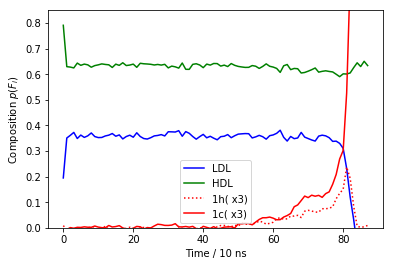

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

#DataClass
class Plot:
    def __init__(self, label, color, style):
        self.label = label
        self.color = color
        self.style = style
        
plots = [Plot("LDL", "b", "-"),
         Plot("HDL", "g", "-"),
         Plot("1h", "r", ":"),
         Plot("1c", "r", "-")]

for i, phase in enumerate(plots):
    if phase.label in ("1h", "1c"):
        plt.plot(fits[:,i]*3, label=phase.label + "( x3)", color=phase.color, linestyle=phase.style)
    else:
        plt.plot(fits[:,i], label=phase.label, color=phase.color, linestyle=phase.style)
plt.legend()
plt.xlabel("Time / 10 ns")
plt.ylabel("Composition $p(F_i)$")
plt.ylim(0,0.85)

plt.savefig("Composition.svg")
plt.show()


In [ ]:
The following codes are for preparing figures in the paper. They are useless without the original data.

X = np.vstack([LDL.reshape([1600,]),
               HDL.reshape([1600,]),
               OneH.reshape([1600,]),
               OneC.reshape([1600,]),]).T

LEN=80
fits = np.zeros([LEN,4])
for fn in range(LEN):
    vals = valueloader(os.popen("cat /Volumes/workarea/work/LL-yaga/ST2-for-tknbn/235K-0.98/00{0:03d}.btwc".format(fn)))
    chirs = vals[:,3]
    chiis = vals[:,4]

    Htarget = np.histogram2d(chirs, chiis, bins=(40,40), range=[[-1.,1.],[-1.,1.]], normed=True)
    Y = Htarget[0].reshape([1600,])
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(X,Y)
    # print(fn, reg.coef_) # , reg.intercept_
    fits[fn] = reg.coef_.copy()
        

In [ ]:
for i, phase in enumerate(["LDL","HDL","1h","1c"]):
    if phase in ("1h", "1c"):
        plt.plot(fits[:,i]*10, label=phase + "( x10)")
    else:
        plt.plot(fits[:,i], label=phase)
plt.legend()
plt.xlabel("Time / ns")
plt.ylabel("Composition $p(F_i)$")

In [ ]:
plt.savefig("Composition0.svg")